# Sine-Gaussian

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device=}")

Using device=device(type='cpu')


In [3]:
def sine_gaussian(t, f_0, tau, shift=0):
    t_shift = t - shift
    data = torch.exp(-1*t_shift*t_shift / tau / tau) * torch.sin(2*torch.pi*f_0 * t_shift)
    return data

def sine_gaussian_bilby(t, f_0, tau, shift=0):
    t_shift = t - shift
    data = np.exp(-1*t_shift*t_shift / tau / tau) * np.sin(2*np.pi*f_0 * t_shift)
    return data

## Plot

Text(0.5, 1.0, 'Time Shifted Signal for f_0 = 1.0, tau = 4.0')

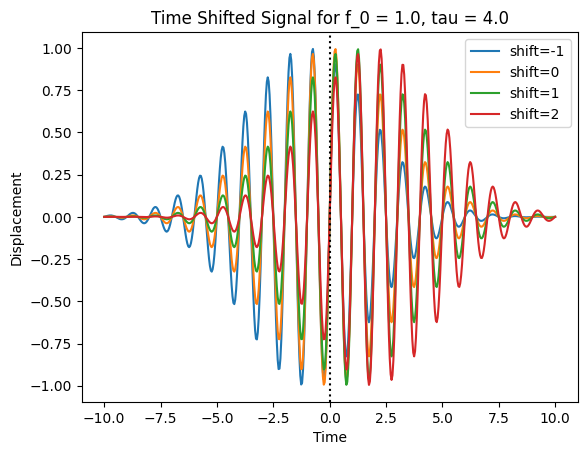

In [4]:
f_0 = torch.tensor(1)
tau = torch.tensor(4)

t_vals = torch.linspace(-10, 10, 500)
for shift in [-1, 0, 1, 2]:
    x_vals = sine_gaussian(t_vals, f_0=f_0, tau=tau, shift=shift)
    plt.plot(t_vals, x_vals, label=f"{shift=}")
plt.xlabel("Time")
plt.ylabel("Displacement")
plt.axvline(x=0, linestyle='dotted', color='black')
plt.legend()
plt.title(f"Time Shifted Signal for f_0 = {f_0:.1f}, tau = {tau:.1f}")

In [5]:
injection_parameters = dict(f_0=f_0, tau=tau, shift=0)
print(injection_parameters)

{'f_0': tensor(1), 'tau': tensor(4), 'shift': 0}


In [6]:
num_points = 500
t_vals = np.linspace(-10, 10, num_points)

In [7]:
sigma = 0.4

In [8]:
data = sine_gaussian_bilby(t_vals, **injection_parameters) + np.random.normal(0, sigma, t_vals.size)

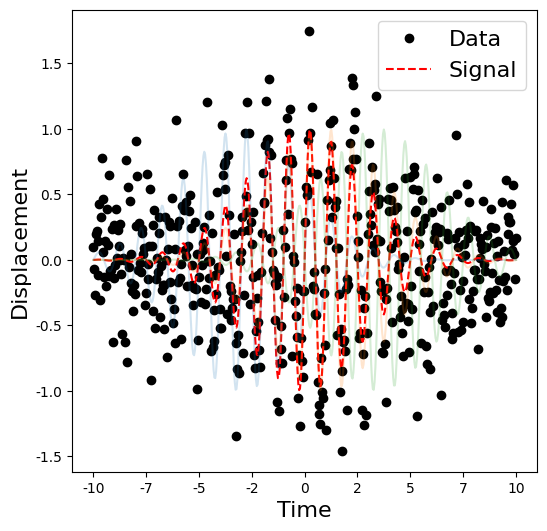

In [9]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(t_vals, data, 'ko', label=r'Data')
ax.plot(t_vals, sine_gaussian(t_vals, **injection_parameters), '--r', label=r'Signal')
for shift in [-3, 1, 3.5]:
    x_vals = sine_gaussian_bilby(t_vals, f_0=f_0, tau=tau, shift=shift)
    plt.plot(t_vals, x_vals, alpha = 0.2)
ax.legend(fontsize=16, loc='upper right')
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Displacement', fontsize=16)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.savefig('./sg-data.pdf')
# plt.title('Data and Signal for Sine-Gaussian')

In [10]:
import bilby
from bilby.core.prior import Uniform, DeltaFunction

## Prior for parameters

In [11]:
priors = dict()

priors['f_0'] = Uniform(0.1, 1, name='f_0', latex_label='$f_0$')
priors['tau'] = Uniform(1, 4, name='tau', latex_label='$\\tau$')
priors['shift'] = Uniform(-2, 2, name='shift', latex_label='$\Delta\;t$')

# Train embedding space first

The aim is to make the network be agnostic to shift in time. Train embedding space to cluster shifts in intercept value.

In [12]:
from IPython.display import clear_output
from time import sleep

In [13]:
import torch

def get_data(f_0=None, tau=None, shift=None, num_points=1):
    """Sample omega, tau, shift and return a batch of data with noise"""

    f_0 = priors['f_0'].sample() if f_0 is None else f_0
    f_0 = torch.tensor(f_0).to(dtype=torch.float32)
    tau = priors['tau'].sample() if tau is None else tau
    tau = torch.tensor(tau).to(dtype=torch.float32)
    shift = priors['shift'].sample() if shift is None else shift
    shift = torch.tensor(shift).to(dtype=torch.float32)

    t_vals = torch.linspace(-10, 10, num_points).to(dtype=torch.float32) #

    y = sine_gaussian(t_vals, f_0=f_0, tau=tau, shift=shift)
    y += sigma * torch.randn(size=y.size()).to(dtype=torch.float32)

    return t_vals, y, f_0, tau, shift

# Add augmentation

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter

In [15]:
num_simulations = 100000
num_repeats = 10

In [16]:
%%time

theta_unshifted_vals = []
theta_shifted_vals = []
data_unshifted_vals = []
data_shifted_vals = []

for ii in range(num_simulations):
    # generated data with a fixed shift
    t_vals, y_unshifted, f_0, tau, shift = get_data(num_points=num_points, shift=1)
    # create repeats
    theta_unshifted = torch.tensor([f_0, tau, shift]).repeat(num_repeats, 1)
    theta_unshifted_vals.append(theta_unshifted)
    data_unshifted_vals.append(y_unshifted.repeat(num_repeats, 1))
    # generate shifted data
    theta_shifted = []
    data_shifted = []
    for _ in range(num_repeats):
        t_val, y_shifted, _f_0, _tau, shift = get_data(
            f_0=f_0, tau=tau,  # omega and tau same as above
            shift=None,
            num_points=num_points
        )
        theta_shifted.append(torch.tensor([f_0, tau, shift]))
        data_shifted.append(y_shifted)
    theta_shifted_vals.append(torch.stack(theta_shifted))
    data_shifted_vals.append(torch.stack(data_shifted))

/tmp/ipykernel_2236545/3667999847.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f_0 = torch.tensor(f_0).to(dtype=torch.float32)
/tmp/ipykernel_2236545/3667999847.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tau = torch.tensor(tau).to(dtype=torch.float32)


CPU times: user 1min 50s, sys: 2.16 s, total: 1min 52s
Wall time: 1min 52s


In [17]:
class DataGenerator(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # return shifted and unshifted theta and data
        return (
            theta_shifted_vals[idx].to(dtype=torch.float32, device=device),
            theta_unshifted_vals[idx].to(dtype=torch.float32, device=device),
            data_shifted_vals[idx].to(dtype=torch.float32, device=device),
            data_unshifted_vals[idx].to(dtype=torch.float32, device=device))

In [18]:
dataset = DataGenerator()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


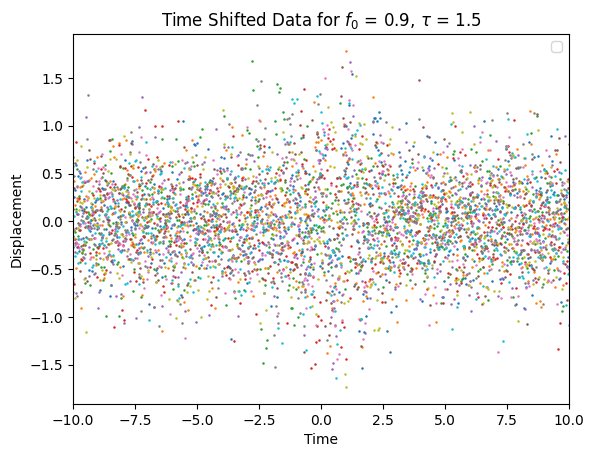

In [19]:
_, t, d, _ = dataset[8]

fig, ax = plt.subplots()

for (omega, tau, shift), points in zip(t, d):
    ax.plot(t_vals.clone().detach().cpu().numpy(),
            points.clone().detach().cpu().numpy(),
            'o', markersize=0.8)
ax.set_xlabel('Time')
ax.set_ylabel('Displacement')
ax.set_title(f"Time Shifted Data for $f_0$ = {t[0][0]:.1f}, $\\tau$ = {t[0][1]:.1f}")
plt.xlim([-10, 10])
plt.legend()

In [20]:
train_set_size = int(0.8 * num_simulations)
val_set_size = int(0.1 * num_simulations)
test_set_size = int(0.1 * num_simulations)

train_data, val_data, test_data = torch.utils.data.random_split(
    dataset, [train_set_size, val_set_size, test_set_size])

In [21]:
TRAIN_BATCH_SIZE = 1000
VAL_BATCH_SIZE = 1000

train_data_loader = DataLoader(
    train_data, batch_size=TRAIN_BATCH_SIZE,
    shuffle=True
)

val_data_loader = DataLoader(
    val_data, batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_data_loader = DataLoader(
    test_data, batch_size=1,
    shuffle=False
)

In [22]:
for theta, _, data_aug, data_orig in train_data_loader:
    break

In [23]:
len(train_data_loader), len(val_data_loader), len(test_data_loader)

(80, 10, 10000)

In [24]:
theta.shape, data_aug.shape, data_orig.shape

(torch.Size([1000, 10, 3]),
 torch.Size([1000, 10, 500]),
 torch.Size([1000, 10, 500]))

## Define similarity loss

In [25]:
# implemented from https://github.com/violatingcp/codec
class VICRegLoss(nn.Module):
    def forward(self, x, y, wt_repr=1.0, wt_cov=1.0, wt_std=1.0):
        repr_loss = F.mse_loss(x, y)

        x = x - x.mean(dim=0)
        y = y - y.mean(dim=0)
        N = x.size(0)
        D = x.size(-1)

        std_x = torch.sqrt(x.var(dim=0) + 0.0001)
        std_y = torch.sqrt(y.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        x = (x-x.mean(dim=0))
        y = (y-y.mean(dim=0))

        # transpose dims 1 and 2; keep batch dim i.e. 0, unchanged
        cov_x = (x.transpose(1, 2) @ x) / (N - 1)
        cov_y = (y.transpose(1, 2) @ y) / (N - 1)
        if torch.any(torch.isnan(cov_x)):
            import pdb;pdb.set_trace()
        if torch.any(torch.isnan(cov_y)):
            import pdb;pdb.set_trace()
        cov_loss = self.off_diagonal(cov_x).pow_(2).sum().div(D)
        cov_loss += self.off_diagonal(cov_y).pow_(2).sum().div(D)

        s = wt_repr*repr_loss + wt_cov*cov_loss + wt_std*std_loss
        return s, repr_loss, cov_loss, std_loss

    def off_diagonal(self,x):
        num_batch, n, m = x.shape
        assert n == m
        # All off diagonal elements from complete batch flattened
        return x.flatten(start_dim=1)[...,:-1].view(num_batch, n - 1, n + 1)[...,1:].flatten()

In [26]:
vicreg_loss = VICRegLoss()

In [27]:
# simplified implemenation from nflows
class ConvResidualBlock(nn.Module):
    def __init__(
        self,
        channels,
        kernel_size=5,
        activation=F.relu,
        dropout_probability=0.1,
        use_batch_norm=True,
        zero_initialization=True,
    ):
        super().__init__()
        self.activation = activation

        self.use_batch_norm = use_batch_norm
        if use_batch_norm:
            self.batch_norm_layers = nn.ModuleList(
                [nn.BatchNorm1d(channels, eps=1e-3) for _ in range(2)]
            )
        self.conv_layers = nn.ModuleList(
            [nn.Conv1d(channels, channels, kernel_size=kernel_size, padding='same') for _ in range(2)] 
        )
        self.dropout = nn.Dropout(p=dropout_probability)
        if zero_initialization:
            nn.init.uniform_(self.conv_layers[-1].weight, -1e-3, 1e-3)
            nn.init.uniform_(self.conv_layers[-1].bias, -1e-3, 1e-3)

    def forward(self, inputs):
        temps = inputs
        if self.use_batch_norm:
            temps = self.batch_norm_layers[0](temps)
        temps = self.activation(temps)
        temps = self.conv_layers[0](temps)
        if self.use_batch_norm:
            temps = self.batch_norm_layers[1](temps)
        temps = self.activation(temps)
        temps = self.dropout(temps)
        temps = self.conv_layers[1](temps)
        return inputs + temps


class ConvResidualNet(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        hidden_channels,
        num_blocks=4,
        kernel_size=5,
        activation=F.relu,
        dropout_probability=0.1,
        use_batch_norm=True,
    ):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.initial_layer = nn.Conv1d(
            in_channels=in_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size,
            padding='same',
        )
        self.blocks = nn.ModuleList(
            [
                ConvResidualBlock(
                    channels=hidden_channels,
                    activation=activation,
                    dropout_probability=dropout_probability,
                    use_batch_norm=use_batch_norm,
                    kernel_size=kernel_size,
                )
                for _ in range(num_blocks)
            ]
        )
        self.final_layer = nn.Conv1d(
            hidden_channels, out_channels, kernel_size=1, padding='same'
        )

    def forward(self, inputs):
        temps = self.initial_layer(inputs)
        for block in self.blocks:
            temps = block(temps)
        outputs = self.final_layer(temps)
        return outputs

In [28]:
num_dim = 3

class SimilarityEmbedding(nn.Module):
    def __init__(self, num_hidden_layers_h=1, activation=torch.tanh):
        super().__init__()
        self.num_hidden_layers_h = num_hidden_layers_h

        self.layers_f = ConvResidualNet(in_channels=num_repeats, out_channels=1,
                                        hidden_channels=10, num_blocks=4,
                                        kernel_size=11)
        self.contraction_layer = nn.Sequential(
            nn.Linear(num_points, 100),
            nn.ReLU(),
            nn.Linear(100, num_dim)
        )
        self.expander_layer = nn.Linear(num_dim, 20)
        self.layers_h = nn.ModuleList([nn.Linear(20, 20) for _ in range(num_hidden_layers_h)])
        self.final_layer = nn.Linear(20, 12)

        self.activation = activation

    def forward(self, x):
        x = self.layers_f(x)
        x = x.mean(dim=1, keepdims=True)
        x = self.contraction_layer(x)
        representation = torch.clone(x)
        x = self.activation(self.expander_layer(x))
        for layer in self.layers_h:
            x = layer(x)
            x = self.activation(x)
        x = self.final_layer(x)
        return x, representation

In [29]:
similarity_embedding = SimilarityEmbedding(num_hidden_layers_h=2).to(device)

In [30]:
optimizer = optim.Adam(similarity_embedding.parameters(), lr=5e-3)
scheduler_1 = optim.lr_scheduler.ConstantLR(optimizer, total_iters=20)
scheduler_2 = optim.lr_scheduler.OneCycleLR(optimizer, total_steps=20, max_lr=5e-4)
scheduler_3 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
scheduler = optim.lr_scheduler.SequentialLR(
    optimizer, schedulers=[scheduler_1, scheduler_2, scheduler_3], milestones=[20, 40])

In [31]:
embed, rep = similarity_embedding(data_aug)
embed.shape, rep.shape

(torch.Size([1000, 1, 12]), torch.Size([1000, 1, 3]))

In [32]:
emb_aug, rep_aug = similarity_embedding(data_aug)
emb_orig, rep_orig = similarity_embedding(data_orig)
vicreg_loss(emb_aug, emb_orig)

(tensor(0.9897, grad_fn=<AddBackward0>),
 tensor(1.4102e-05, grad_fn=<MseLossBackward0>),
 tensor(2.1148e-12, grad_fn=<AddBackward0>),
 tensor(0.9897, grad_fn=<AddBackward0>))

In [33]:
for theta, _, data_aug, data_orig in val_data_loader:
    break

In [34]:
emb_aug, rep_aug = similarity_embedding(data_aug)
emb_orig, rep_orig = similarity_embedding(data_orig)
vicreg_loss(emb_aug, emb_orig)

(tensor(0.9897, grad_fn=<AddBackward0>),
 tensor(1.2777e-05, grad_fn=<MseLossBackward0>),
 tensor(1.8466e-12, grad_fn=<AddBackward0>),
 tensor(0.9897, grad_fn=<AddBackward0>))

In [35]:
def train_one_epoch(epoch_index, tb_writer, **vicreg_kwargs):
    running_sim_loss = 0.
    last_sim_loss = 0.

    for idx, val in enumerate(train_data_loader):
        augmented_theta, _, augmented_data, unshifted_data = val
        embedded_values_aug, _ = similarity_embedding(augmented_data)
        embedded_values_orig, _ = similarity_embedding(unshifted_data)
        sim_loss = 0

        similar_embedding_loss, _repr, _cov, _std = vicreg_loss(
            embedded_values_aug,
            embedded_values_orig,
            **vicreg_kwargs
        )
        sim_loss += similar_embedding_loss
        optimizer.zero_grad()
        sim_loss.backward()
        optimizer.step()
        # Gather data and report
        running_sim_loss += sim_loss.item()
        if idx % 10 == 0:
            last_sim_loss = running_sim_loss / 10
            tb_x = epoch_index * len(train_data_loader) + idx
            tb_writer.add_scalar('SimLoss/train', last_sim_loss, tb_x)
            running_sim_loss = 0.
    return last_sim_loss


def val_one_epoch(epoch_index, tb_writer, **vicreg_kwargs):
    running_sim_loss = 0.
    last_sim_loss = 0.

    for idx, val in enumerate(val_data_loader):
        augmented_theta, _, augmented_data, unshifted_data = val
        embedded_values_aug, _ = similarity_embedding(augmented_data)
        embedded_values_orig, _ = similarity_embedding(unshifted_data)
        sim_loss = 0

        similar_embedding_loss, _repr, _cov, _std = vicreg_loss(
            embedded_values_aug,
            embedded_values_orig,
            **vicreg_kwargs
        )
        sim_loss += similar_embedding_loss

        running_sim_loss += sim_loss.item()
        if idx % 5 == 0:
            last_sim_loss = running_sim_loss / 5
            tb_x = epoch_index * len(val_data_loader) + idx + 1
            tb_writer.add_scalar('SimLoss/val', last_sim_loss, tb_x)
            tb_writer.flush()
            print(f'Last {_repr.item():.2f}; {_cov.item():.2f}; {_std.item():.2f}')
            running_sim_loss = 0.
    tb_writer.flush()
    return last_sim_loss

In [36]:
# writer = SummaryWriter("sine-gaussian-similarity-embedding-training.neurips", flush_secs=5)
# epoch_number = 0

In [37]:
sum_param=0
for name, param in similarity_embedding.named_parameters():
    if param.requires_grad:
        sum_param+=param.numel()
print(sum_param)

61736


In [38]:
PATH = './sine-gaussian-similarity-embedding-weights.neurips.pth'
similarity_embedding.load_state_dict(torch.load(PATH, map_location=device))
similarity_embedding.eval()

SimilarityEmbedding(
  (layers_f): ConvResidualNet(
    (initial_layer): Conv1d(10, 10, kernel_size=(11,), stride=(1,), padding=same)
    (blocks): ModuleList(
      (0): ConvResidualBlock(
        (batch_norm_layers): ModuleList(
          (0): BatchNorm1d(10, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (1): BatchNorm1d(10, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv_layers): ModuleList(
          (0): Conv1d(10, 10, kernel_size=(11,), stride=(1,), padding=same)
          (1): Conv1d(10, 10, kernel_size=(11,), stride=(1,), padding=same)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): ConvResidualBlock(
        (batch_norm_layers): ModuleList(
          (0): BatchNorm1d(10, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (1): BatchNorm1d(10, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv_layers): ModuleList(
         

In [39]:
# %%time
# UNCOMMENT AND RUN TO TRAIN FROM SCRATCH
# EPOCHS = 100

# for epoch in range(EPOCHS):
#     print('EPOCH {}:'.format(epoch_number + 1))
#     wt_repr, wt_cov, wt_std = (1, 1, 1)

#     if epoch < 20:
#         wt_repr, wt_cov, wt_std = (5, 1, 5)
#     elif epoch < 45:
#         wt_repr, wt_cov, wt_std = (2, 2, 1)


#     print(f"VicReg wts: {wt_repr=} {wt_cov=} {wt_std=}")
#     # Gradient tracking
#     similarity_embedding.train(True)
#     avg_train_loss = train_one_epoch(epoch_number, writer,
#                                      wt_repr=wt_repr, wt_cov=wt_cov, wt_std=wt_std)
    
#     # no gradient tracking, for validation
#     similarity_embedding.train(False)
#     avg_val_loss = val_one_epoch(epoch_number, writer,
#                                  wt_repr=wt_repr, wt_cov=wt_cov, wt_std=wt_std)
    
#     print(f"Train/Val Sim Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")

#     epoch_number += 1
#     scheduler.step()

In [40]:
# PATH = './sine-gaussian-similarity-embedding-weights.neurips.pth'
# torch.save(similarity_embedding.state_dict(), PATH)

## See embedded space

# Varying Omega

In [41]:
# C1 orange
# C2 green
# C3 red
# C4 purple

similarity_outputs_1 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test.T[0][0][0] < 0.4) and (theta_test.T[0][0][0] > 0.2)):
        continue
    with torch.no_grad():
        for ii in range(num_repeats):
            _, similarity_output = similarity_embedding(data_test)
            similarity_outputs_1.append(similarity_output)

similarity_outputs_2 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test.T[0][0][0] < 0.8) and (theta_test.T[0][0][0] > 0.6)):
        continue
    with torch.no_grad():
        for ii in range(num_repeats):
            _, similarity_output = similarity_embedding(data_test)
            similarity_outputs_2.append(similarity_output)

similarity_outputs_3 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test.T[0][0][0] < 0.6) and (theta_test.T[0][0][0] > 0.4)):
        continue
    with torch.no_grad():
        for ii in range(num_repeats):
            _, similarity_output = similarity_embedding(data_test)
            similarity_outputs_3.append(similarity_output)

/tmp/ipykernel_2236545/2488433133.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2981.)
  if not ((theta_test.T[0][0][0] < 0.4) and (theta_test.T[0][0][0] > 0.2)):


In [42]:
similarity_outputs_1 = torch.stack(similarity_outputs_1).squeeze()
similarity_outputs_2 = torch.stack(similarity_outputs_2).squeeze()
similarity_outputs_3 = torch.stack(similarity_outputs_3).squeeze()

In [43]:
similarity_outputs_1.shape

torch.Size([22020, 3])

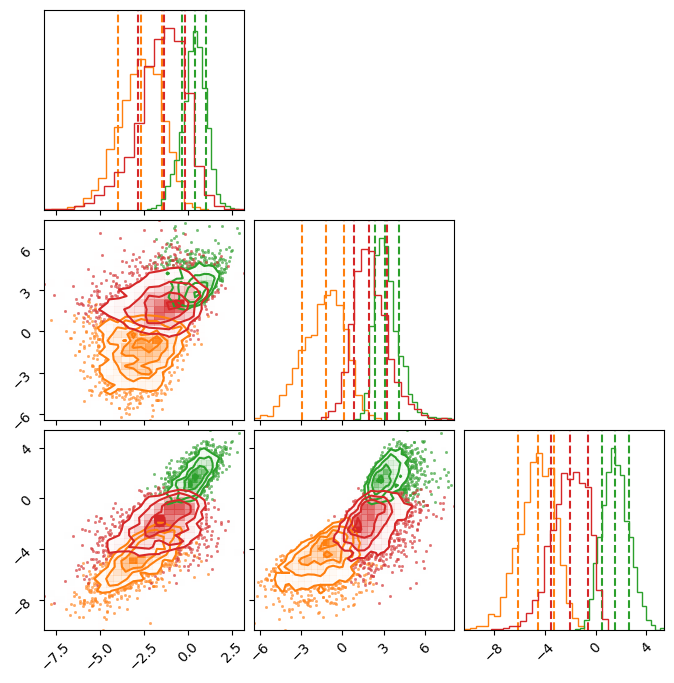

In [44]:
import corner

figure = corner.corner(
    similarity_outputs_1.cpu().numpy().reshape(-1, num_dim),
    quantiles=[0.16, 0.5, 0.84], color="C1"
)

figure = corner.corner(
    similarity_outputs_2.cpu().numpy().reshape(-1, num_dim),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C2"
)

figure = corner.corner(
    similarity_outputs_3.cpu().numpy().reshape(-1, num_dim),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C3"
)

# Varying Tau

In [45]:
similarity_embedding.train(False)

similarity_outputs_1 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test.T[0][1][0] < 0.2) and (theta_test.T[0][1][0] > 0.1)):
        continue
    with torch.no_grad():
        for ii in range(num_repeats):
            _, similarity_output = similarity_embedding(data_test)
            similarity_outputs_1.append(similarity_output)

similarity_outputs_2 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test.T[0][1][0] < 0.3) and (theta_test.T[0][1][0] > 0.2)):
        continue
    with torch.no_grad():
        for ii in range(num_repeats):
            _, similarity_output = similarity_embedding(data_test)
            similarity_outputs_2.append(similarity_output)

similarity_outputs_3 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test.T[0][1][0] < 0.4) and (theta_test.T[0][1][0] > 0.3)):
        continue
    with torch.no_grad():
        for ii in range(num_repeats):
            _, similarity_output = similarity_embedding(data_test)
            similarity_outputs_3.append(similarity_output)

similarity_outputs_4 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test.T[0][1][0] < 0.5) and (theta_test.T[0][1][0] > 0.4)):
        continue
    with torch.no_grad():
        for ii in range(num_repeats):
            _, similarity_output = similarity_embedding(data_test)
            similarity_outputs_4.append(similarity_output)

In [46]:
similarity_outputs_1 = torch.stack(similarity_outputs_1)
similarity_outputs_2 = torch.stack(similarity_outputs_2)
similarity_outputs_3 = torch.stack(similarity_outputs_3)
similarity_outputs_4 = torch.stack(similarity_outputs_4)

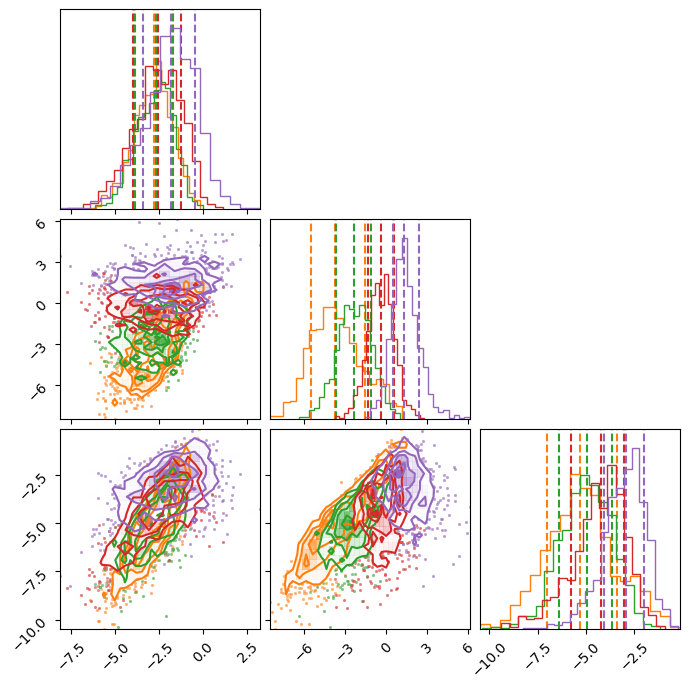

In [47]:
import corner

figure = corner.corner(
    similarity_outputs_1.cpu().numpy().reshape((similarity_outputs_1.shape[0]*similarity_outputs_1.shape[2], num_dim)),
    quantiles=[0.16, 0.5, 0.84], color="C1"
)

figure = corner.corner(
    similarity_outputs_2.cpu().numpy().reshape((similarity_outputs_2.shape[0]*similarity_outputs_2.shape[2], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C2"
)

figure = corner.corner(
    similarity_outputs_3.cpu().numpy().reshape((similarity_outputs_3.shape[0]*similarity_outputs_3.shape[2], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C3"
)

figure = corner.corner(
    similarity_outputs_4.cpu().numpy().reshape((similarity_outputs_4.shape[0]*similarity_outputs_4.shape[2], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C4"
)

# Varying Omega with constant Tau

- can get better results with changing the training and testing data sizes to 0.1 and 0.8 respectively

In [48]:
#orange green red purple

similarity_outputs_1 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test[0][0][0] < 0.75) and (theta_test[0][0][0] > 0.5) and \
            (theta_test[0][0][1] < 1.3) and (theta_test[0][0][1] > 1.2)):
        continue
    with torch.no_grad():
        for ii in range(num_repeats):
            _, similarity_output = similarity_embedding(data_test)
            similarity_outputs_1.append(similarity_output)

similarity_outputs_2 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test[0][0][0] < 0.5) and (theta_test[0][0][0] > 0.25) and \
            (theta_test[0][0][1] < 1.2) and (theta_test[0][0][1] > 1.1)):
        continue
    with torch.no_grad():
        for ii in range(num_repeats):
            _, similarity_output = similarity_embedding(data_test)
            similarity_outputs_2.append(similarity_output)
    
similarity_outputs_3 = []

for idx, (_, theta_test, data_test, data_test_orig) in enumerate(test_data_loader):
    if not ((theta_test[0][0][0] < 0.5) and (theta_test[0][0][0] > 0.25) and \
            (theta_test[0][0][1] < 1.5) and (theta_test[0][0][1] > 1.4)):
        continue
    with torch.no_grad():
        for ii in range(num_repeats):
            _, similarity_output = similarity_embedding(data_test)
            similarity_outputs_3.append(similarity_output)

In [49]:
similarity_outputs_1 = torch.stack(similarity_outputs_1)
similarity_outputs_2 = torch.stack(similarity_outputs_2)
similarity_outputs_3 = torch.stack(similarity_outputs_3)

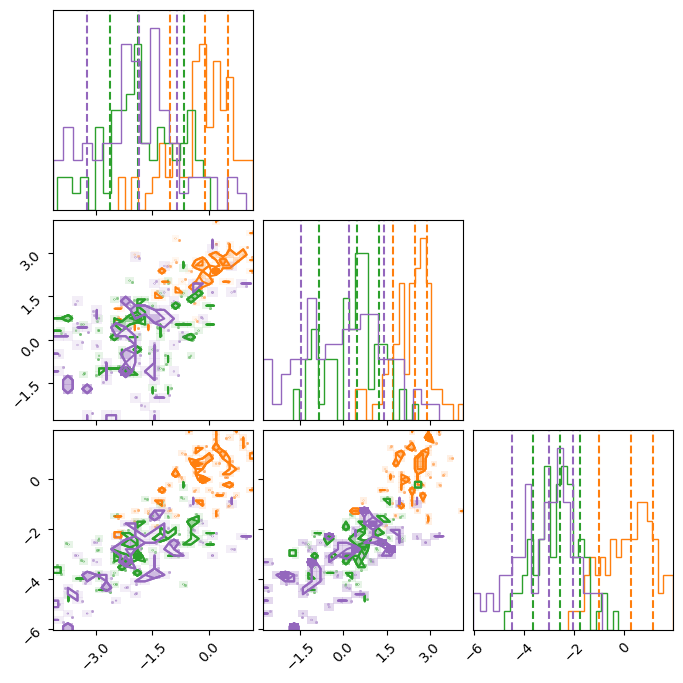

In [50]:
import corner

figure = corner.corner(
    similarity_outputs_1.cpu().numpy().reshape((similarity_outputs_1.shape[0]*similarity_outputs_1.shape[2], num_dim)),
    quantiles=[0.16, 0.5, 0.84], color="C1"
)

figure = corner.corner(
    similarity_outputs_2.cpu().numpy().reshape((similarity_outputs_2.shape[0]*similarity_outputs_2.shape[2], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C2"
)

figure = corner.corner(
    similarity_outputs_3.cpu().numpy().reshape((similarity_outputs_3.shape[0]*similarity_outputs_3.shape[2], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C4"
)

# Freeze weights, used as embedding network in MAF

In [51]:
from nflows.distributions import StandardNormal, ConditionalDiagonalNormal
from nflows.flows import Flow
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms import CompositeTransform, RandomPermutation
import nflows.utils as torchutils

In [52]:
class EmbeddingNet(nn.Module):
    """Wrapper around the similarity embedding defined above"""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.representation_net = SimilarityEmbedding(num_hidden_layers_h=2)
        self.representation_net.load_state_dict(similarity_embedding.state_dict())

        # the expander network is unused and hence don't track gradients
        for name, param in self.representation_net.named_parameters():
            if 'expander_layer' in name or 'layers_h' in name or 'final_layer' in name:
                param.requires_grad = False

        # freeze part of the conv layer of embedding_net
        for name, param in self.representation_net.named_parameters():
            if 'layers_f' in name:
                param.requires_grad = False
        self.context_layer = nn.Sequential(
            nn.Linear(num_dim, 1000),
            nn.ReLU(),
            nn.Linear(1000, num_dim)
        )
    def forward(self, x):
        batch_size, _, dims = x.shape
        x = x.reshape(batch_size, 1, dims).repeat(1, num_repeats, 1)
        _, rep = self.representation_net(x)
        return self.context_layer(rep.reshape(batch_size, num_dim))

In [53]:
num_transforms = 5
num_blocks = 4
hidden_features = 20

embedding_net = EmbeddingNet().to(device)

context_features = num_dim

base_dist = StandardNormal([2])

transforms = []
for _ in range(num_transforms):
    block = [
        MaskedAffineAutoregressiveTransform(
            features=2,  # 2-dim posterior
            hidden_features=hidden_features,
            context_features=context_features,
            num_blocks=num_blocks,
            activation=torch.tanh,
            use_batch_norm=False,
            use_residual_blocks=True,
            dropout_probability=0.01,
        ),
        RandomPermutation(features=2)
    ]
    transforms += block

transform = CompositeTransform(transforms)


flow = Flow(transform, base_dist, embedding_net).to(device=device)

In [54]:
sum(p.numel() for p in flow._embedding_net.parameters() if p.requires_grad)

57406

In [55]:
print("Total number of trainable parameters: ", sum(p.numel() for p in flow.parameters() if p.requires_grad))

Total number of trainable parameters:  76926


# Train/Validate

In [56]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(train_data_loader, 1):
        augmented_theta, _, augmented_data, _ = val
        augmented_theta = augmented_theta[...,0:2]

        theta = augmented_theta.reshape(-1, 2)
        data = augmented_data.reshape(-1, 1, num_points)

        flow_loss = -flow.log_prob(theta, context=data).mean()

        optimizer.zero_grad()
        flow_loss.backward()
        optimizer.step()

        running_loss += flow_loss.item()
        if idx % 10 == 0:
            last_loss = running_loss / 10 # avg loss
            #print(' Avg. train loss/batch after {} batches = {:.4f}'.format(idx, last_loss))
            tb_x = epoch_index * len(train_data_loader) + idx
            tb_writer.add_scalar('Flow Loss/train', last_loss, tb_x)
            tb_writer.flush()
            running_loss = 0.
    return last_loss


def val_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(val_data_loader, 1):
        augmented_theta, _, augmented_data, _ = val
        augmented_theta = augmented_theta[...,0:2]

        theta = augmented_theta.reshape(-1, 2)
        data = augmented_data.reshape(-1, 1, num_points)

        flow_loss = -flow.log_prob(theta, context=data).mean()
        loss = flow_loss.item()

        running_loss += flow_loss.item()
        if idx % 5 == 0:
            last_loss = running_loss / 5
            tb_x = epoch_index * len(val_data_loader) + idx + 1
            tb_writer.add_scalar('Flow Loss/val', last_loss, tb_x)

            tb_writer.flush()
            running_loss = 0.
    tb_writer.flush()
    return last_loss

In [57]:
optimizer = optim.Adam(flow.parameters(), lr=1e-3)

scheduler_1 = optim.lr_scheduler.ConstantLR(optimizer, total_iters=5)
scheduler_2 = optim.lr_scheduler.OneCycleLR(optimizer, total_steps=20, max_lr=1e-3)
scheduler_3 = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

scheduler = optim.lr_scheduler.SequentialLR(
    optimizer, schedulers=[scheduler_1, scheduler_2, scheduler_3], milestones=[5, 20])
# optimizer = optim.SGD(flow.parameters(), lr=5e-4, momentum=0.5)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, threshold=0.01)

In [58]:
# writer = SummaryWriter("sg-flow-with-embedding.neurips", flush_secs=5)
# epoch_number = 0

In [59]:
# %%time
# UNCOMMENT AND RUN TO TRAIN FROM SCRATCH
# EPOCHS = 100

# for epoch in range(EPOCHS):
#     print('EPOCH {}:'.format(epoch_number + 1))
#     # Gradient tracking
#     flow.train(True)
#     avg_train_loss = train_one_epoch(epoch_number, writer)

#     # no gradient tracking, for validation
#     flow.train(False)
#     avg_val_loss = val_one_epoch(epoch_number, writer)

#     print(f"Train/Val flow Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")
#     for param_group in optimizer.param_groups:
#         print("Current LR = {:.3e}".format(param_group['lr']))
#     epoch_number += 1
#     try:
#         scheduler.step(avg_val_loss)
#     except TypeError:
#         scheduler.step()

In [60]:
flow_path = './sg-with-similarity-embedding-flow-weights.neurips.pth'
# torch.save(flow.state_dict(), flow_path)
flow.load_state_dict(torch.load(flow_path, map_location=device))
flow.eval()

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=2, out_features=20, bias=True)
          (context_layer): Linear(in_features=3, out_features=20, bias=True)
          (blocks): ModuleList(
            (0): MaskedResidualBlock(
              (context_layer): Linear(in_features=3, out_features=20, bias=True)
              (linear_layers): ModuleList(
                (0): MaskedLinear(in_features=20, out_features=20, bias=True)
                (1): MaskedLinear(in_features=20, out_features=20, bias=True)
              )
              (dropout): Dropout(p=0.01, inplace=False)
            )
            (1): MaskedResidualBlock(
              (context_layer): Linear(in_features=3, out_features=20, bias=True)
              (linear_layers): ModuleList(
                (0): MaskedLinear(in_features=20, out_features=20, bias=True)
       

#### Profile MACs

In [61]:
from torchprofile import profile_macs

In [62]:
data = torch.randn(1000, 1, num_points).to(device)
theta = torch.randn(1000, 2).to(device)
num_macs_embed = profile_macs(flow._embedding_net, args=(data,))
embedded_data = flow._embedding_net(data)

/work/submit/deep1018/miniconda3/envs/mlpe-base/lib/python3.9/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::reshape". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/work/submit/deep1018/miniconda3/envs/mlpe-base/lib/python3.9/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::repeat". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/work/submit/deep1018/miniconda3/envs/mlpe-base/lib/python3.9/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::_convolution_mode". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


In [63]:
num_macs_forward = profile_macs(flow._transform, args=(theta, embedded_data))
print("#MACs: {:.2e}".format(num_macs_forward+num_macs_embed))

#MACs: 1.15e+08


/work/submit/deep1018/miniconda3/envs/mlpe-base/lib/python3.9/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::new_zeros". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/work/submit/deep1018/miniconda3/envs/mlpe-base/lib/python3.9/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::softplus". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/work/submit/deep1018/miniconda3/envs/mlpe-base/lib/python3.9/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::log". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/work/submit/deep1018/miniconda3/envs/mlpe-base/lib/python3.9/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::index_select". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


# Check on test data

In [64]:
import pandas as pd
import corner
def cast_as_bilby_result(samples, truth):
    injections = dict()
    injections['f_0'] = float(truth.numpy()[0])
    injections['tau'] = float(truth.numpy()[1])

    posterior = dict.fromkeys({'f_0', 'tau'})
    samples_numpy = samples.numpy()
    posterior['f_0'] = samples_numpy.T[0].flatten()
    posterior['tau'] = samples_numpy.T[1].flatten()
    posterior = pd.DataFrame(posterior)

    return bilby.result.Result(
        label="test_data",
        injection_parameters=injections,
        posterior=posterior,
        search_parameter_keys=['f_0', 'tau'],
        priors=priors
    )

In [65]:
def live_plot_samples(samples, truth):
    print(truth)
    clear_output(wait=True)
    sleep(0.5)
    figure = corner.corner(
        samples.numpy(), quantiles=[0.05, 0.5, 0.95],
        show_titles=True,
        labels=["$f_0$", "$\\tau$",],
        truth=truth,
    )

    corner.overplot_lines(figure, truth, color="C1")
    corner.overplot_points(figure, truth[None], marker="s", color="C1")

### See few example posteriors

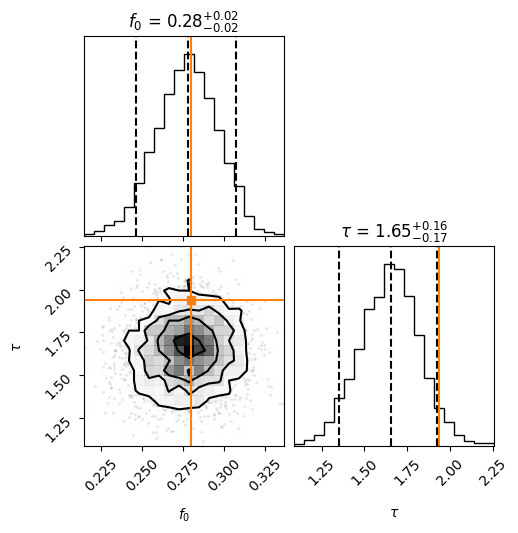

In [66]:
for idx, (_, theta_test, data_test, data_orig) in enumerate(test_data_loader):
    if idx % 500 !=0: continue 
    with torch.no_grad():
        samples = flow.sample(3000, context=data_test[0][0].reshape((1, 1, 500)))
    live_plot_samples(samples.cpu().reshape(3000, 2), theta_test[0][0].cpu()[..., 0:2])
    plt.show()

# PP plot

13:36 bilby INFO    : Key: KS-test p-value
13:36 bilby INFO    : f_0: 0.02992046094313139
13:36 bilby INFO    : tau: 0.37671070978452625
13:36 bilby INFO    : Combined p-value: 0.06182892714905015


CPU times: user 43.5 s, sys: 486 ms, total: 43.9 s
Wall time: 22.8 s


<Figure size 600x600 with 0 Axes>

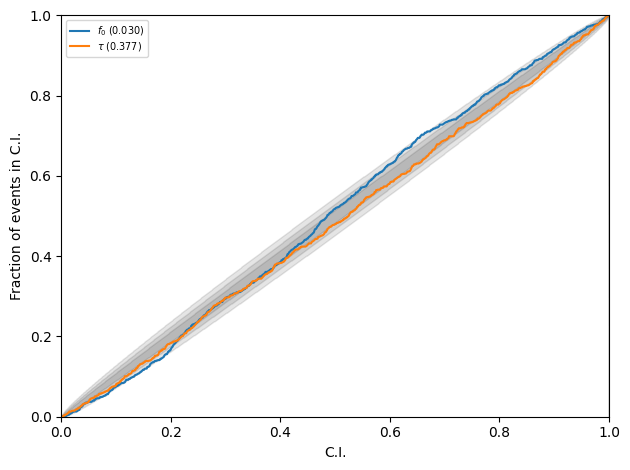

In [67]:
%%time
results = []
for idx, (_, theta_test, data_test, data_unshifted) in enumerate(test_data_loader):
    if idx == 1000: break
    with torch.no_grad():
        samples = flow.sample(3000, context=data_test[0][0].reshape((1, 1, 500)))
    results.append(
        cast_as_bilby_result(samples.cpu().reshape(3000, 2), theta_test[0][0].cpu()[...,0:2]))

plt.figure(figsize=(6, 6))
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bilby.result.make_pp_plot(results, save=False,
                              keys=['f_0', 'tau'], title=None)

# Comparison with bilby and analytic result

In [68]:
import bilby
bilby_result = bilby.result.Result.from_json('./bilby_sg.json', outdir=None)

In [69]:
bilby_result.injection_parameters.pop('shift')
injection_parameters = bilby_result.injection_parameters.copy()

In [70]:
injection_parameters

{'f_0': 0.7, 'tau': 3}

In [71]:
x_vals = sine_gaussian_bilby(t_vals, **injection_parameters)
x_vals = x_vals.to(device, dtype=torch.float32)

In [72]:
with torch.no_grad():
    flow_samples = flow.sample(3000, context=x_vals.reshape((1, 1, 500)))

In [73]:
flow_result = cast_as_bilby_result(flow_samples.cpu().reshape(3000, 2),
                                   torch.tensor(list(injection_parameters.values())))

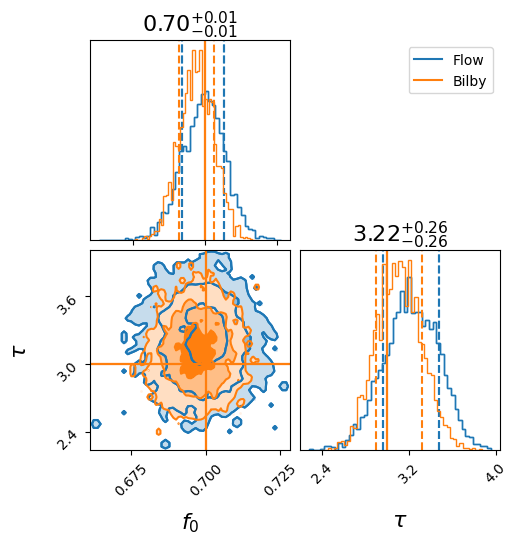

In [74]:
fig = bilby.result.plot_multiple(
    [flow_result, bilby_result],
    labels=['Flow', 'Bilby'],
    truth=injection_parameters,
    corner_labels=[r"$f_0$", r"$\tau$"],
    quantiles=(0.16, 0.84), save=False
)